# Hong Kong Interbank Balance Plot

#### Imports

In [1]:
import pandas as pd
import requests
from requests.adapters import Retry, HTTPAdapter
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import json
import sqlite3


#### Globals

In [2]:
START = '2018-01-01'
END = str(pd.Timestamp.today().date())


#### Utility Functions

In [3]:
def url(Y, M, D):
    return (
        'https://www.hkma.gov.hk/eng/'
        'data-publications-and-research/data-and-statistics/'
        f'daily-monetary-statistics/{Y}/{M}/ms-{Y}{M}{D}/')


In [4]:
def interbank_balance(date):
    try:
        Y, M, D = date.split('-')
        sess = requests.Session()
        sess.mount('https://', HTTPAdapter(max_retries=Retry(total=50, backoff_factor=0.1)))
        resp = sess.get(url(Y, M, D))
        print(f'fetching {date}')
        soup = BeautifulSoup(resp.content)
        table = soup.select_one(
            '#interbank-liquidity + div + div div.collapsibles-accordion-content div.template-table table')
        trs = table.select('tr')
        td = trs[1].select('td')[1]
        clean_text = td.text.replace('mn', '').replace(
            '百萬', '').replace(',', '').strip()
        return float(clean_text)
    except (AttributeError, ):
        return None


#### Tests

In [5]:
for date in ['2022-06-01', '2022-08-01']:
    ib = interbank_balance(date)
    print(date, ib)


fetching 2022-06-01
2022-06-01 319990.0
fetching 2022-08-01
2022-08-01 165158.0


#### Fetch

If connection is banned, wait for a while and run this cell again. Program will only re-download failed fetch.

In [6]:
dates = [str(d.date())
         for d in pd.date_range(START, END)]
with sqlite3.connect('data.sqlite') as conn:
    cursor = conn.cursor()
    for d in dates:
        cursor.execute(f"SELECT * from interbank where Date='{d}'")
        rows = cursor.fetchall()
        if len(rows) == 0:
            val = interbank_balance(d)
            val = val if val is not None else 'NULL'
            cursor.execute(f'INSERT OR REPLACE INTO interbank (Date, Balance) VALUES ("{d}", {val})')
    conn.commit()

fetching 2024-11-14
fetching 2024-11-15
fetching 2024-11-16
fetching 2024-11-17
fetching 2024-11-18
fetching 2024-11-19
fetching 2024-11-20
fetching 2024-11-21
fetching 2024-11-22
fetching 2024-11-23
fetching 2024-11-24
fetching 2024-11-25
fetching 2024-11-26
fetching 2024-11-27
fetching 2024-11-28
fetching 2024-11-29
fetching 2024-11-30
fetching 2024-12-01
fetching 2024-12-02
fetching 2024-12-03
fetching 2024-12-04
fetching 2024-12-05
fetching 2024-12-06
fetching 2024-12-07
fetching 2024-12-08
fetching 2024-12-09
fetching 2024-12-10
fetching 2024-12-11
fetching 2024-12-12
fetching 2024-12-13
fetching 2024-12-14
fetching 2024-12-15
fetching 2024-12-16
fetching 2024-12-17
fetching 2024-12-18
fetching 2024-12-19
fetching 2024-12-20
fetching 2024-12-21
fetching 2024-12-22
fetching 2024-12-23
fetching 2024-12-24
fetching 2024-12-25
fetching 2024-12-26
fetching 2024-12-27
fetching 2024-12-28
fetching 2024-12-29
fetching 2024-12-30
fetching 2024-12-31
fetching 2025-01-01
fetching 2025-01-02


#### Plot

<Axes: title={'center': 'Hong Kong Interbank Balalnce'}, ylabel='million HKD'>

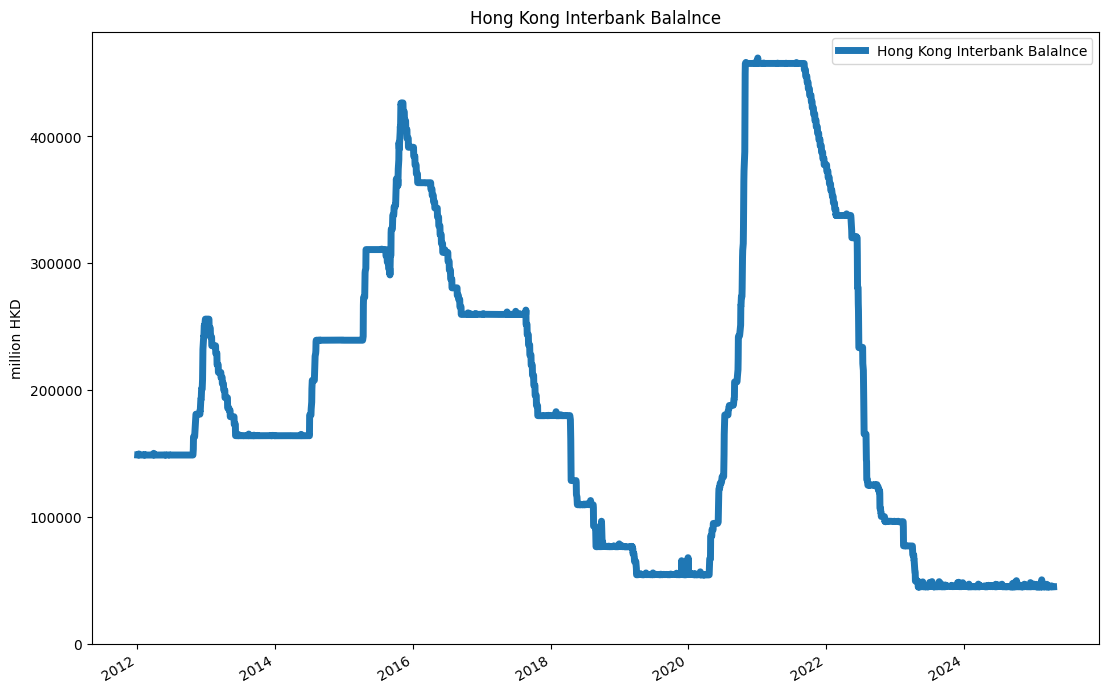

In [7]:
with sqlite3.connect('data.sqlite') as conn:
    cursor = conn.cursor()
    cursor.execute('SELECT * from interbank')
    data = cursor.fetchall()

clean = {d: v for d, v in dict(data).items() if v}
series = pd.Series(clean.values(),
                   index=pd.to_datetime(list(clean.keys())),
                   name='Hong Kong Interbank Balalnce').sort_index()
fig, ax = plt.subplots(1, 1, figsize=(13, 9))
series.plot(ax=ax, ylim=(0, None), title=series.name,
            legend=series.name, ylabel='million HKD', lw=5)


#### Recent

In [8]:
series.sort_index().iloc[-20:]

2025-03-21    44595
2025-03-24    44595
2025-03-25    44595
2025-03-26    45540
2025-03-27    44621
2025-03-28    44621
2025-03-31    44621
2025-04-01    44621
2025-04-02    44694
2025-04-03    44689
2025-04-07    44689
2025-04-08    44709
2025-04-09    44783
2025-04-10    44783
2025-04-11    45476
2025-04-14    44783
2025-04-15    44783
2025-04-16    44674
2025-04-17    44674
2025-04-22    44734
Name: Hong Kong Interbank Balalnce, dtype: int64